# 文档说明

这篇文档对应的内容是文本分类项目第一周结果展示,主要包括下面几个部分:
1. 比较百度中文分词和结巴分词的结果和效率
2. 探索数据分布与分析
3. 编码尝试与结果评估
    3.1 OneHot
    3.2 Embedding与可视化

## 1. 百度中文分词和结巴分词的对比

#### 结论:
(提前上结论了,想了解详细信息的可以继续看下去,不感兴趣的直接跳过这节内容.)

#### jieba分词在处理时间上优于百度中文分词,处理结果没有明显劣势.所以项目后面会继续使用jieba分词.

### 1.1 百度中文分词介绍
    百度中文分词是百度AI开放平台中一个可以免费调用的web api,可以实现对中文语句的分词.更多信息可以参考: http://ai.baidu.com.
    
### 1.2 jieba中文分词介绍
    jieba分词是一个免费的第三方python中文分词类库,可以在本地对中文语句进行分词操作.
    jieba分词提供了三种分词策略:
        a. 精确模式
        b. 全模式
        c. 搜索引擎模式
    更多信息可以参考: https://github.com/fxsjy/jieba

### 1.3 两种分词方式的性能(处理时间)对比
两种分词方式处理分词的位置不同,导致语句的处理时间会有数量级上的差别.
在进行百度分词api调用的时候,这里采用了爬虫框架Scrapy,利用其多线程技术最大化的减少web api调用对处理时间的影响.由于百度ai平台对免费调用的并发量有限制(5),所以爬虫的线程数固定在5条.

进行的具体操作如下:
- 对training.csv里的description内容进行分词.
- 分词结束使用相同的方法去除分词结果中的中文停用词.

| 分词工具 | 数据量 | 用时 |
| :-- | ---: | ---: |
| 百度中文分词 | 4773 | 55 min |
| jieba分词 | 4773 | 30 s |

### 1.4 两种分词处理结果对比
分词结果出来之后,随机挑选了前三个分类里的结果进行比较,得到如下结论:

| | 优点 | 缺点 |
| --- |--- | --- |
| 百度中文分词 | 可以很好的识别一些专业机构和行业标准 | 对某些常用词语组合分词效果不理想.比如"主营业务",分词结果为 '主', '营', '业务' |
| jieba分词 | 对常见词的分词处理比较适中 | 对专业机构和行业标准的识别不理想 |

比如:
#### 百度中文分词:

['合晟资产', '一家', '专注', '股票', '债券', '二级', '市场', '投资', '合格', '投资者', '提供', '专业', '资产', '管理', '服务', '企业', '公司', '业务范围', '包括', '资产', '管理', '投资', '咨询', '投资', '顾问', '服务', '公司', '管理', '私募基金', '产品', '包括', '股票型', '债券型', '资产', '管理', '计划', '证券投资', '基金', '管理', '总', '资产', '规模', '80亿元', '中国证券投资基金业协会', '数据', '公司', '管理', '私募证券投资基金', '顾问', '管理', '类', '规模', '较大', '公司', '管理', '规模', '处于', '50亿元', '第一', '梯队']

#### jieba分词:

['合晟', '资产', '一家', '专注', '股票', '债券', '二级', '市场', '投资', '合格', '投资者', '提供', '专业', '资产', '管理', '服务', '企业', '公司', '业务范围', '包括', '资产', '管理', '投资', '咨询', '投资', '顾问', '服务', '公司', '管理', '私募', '基金', '产品', '包括', '股票', '型', '债券', '型', '资产', '管理', '计划', '证券', '投资', '基金', '管理', '总资产', '规模', '80', '亿元', '中国', '证券', '投资', '基金业', '协会', '数据', '公司', '管理', '私募', '证券', '投资', '基金', '顾问', '管理', '类', '规模', '较大', '公司', '管理', '规模', '处于', '50', '亿元', '第一', '梯队']


### 1.5 那些年踩过的坑

这里的坑主要是百度中文分词里的.
1. 百度中文分词只支持GBK编码,而Scrapy原生的api会对中文语句进行处理,导致传到服务器的时候编码格式不对,从而无法输出结果.
解决方案: 重写Scrapy中间件,使用python的requests进行调用.

2. 百度中文分词无法处理一些特殊符号.
即便已经对所有语句进行了GBK编码,但是有些字符百度还是无法处理.
解决方案: 对所有出错的语句进行分析,把特殊字符找出来,在上传到服务器之前去除特殊字符.

## 2. 数据探索

### 2.1 查看数据分布
查看每个分类的实例分布均匀不均匀

In [17]:
import nltk
from nltk import word_tokenize, sent_tokenize
import gensim
from gensim.models.word2vec import Word2Vec
from sklearn.manifold import TSNE
import pandas as pd
from bokeh.io import output_notebook
from bokeh.plotting import show, figure
import jieba
import matplotlib.pyplot as plt
%matplotlib inline

training_path = '/home/alvin/!Final_Project/training.csv'
testing_path = '/home/alvin/!Final_Project/testing.csv'

df_train = pd.read_csv(training_path, names=['class', 'descriptions'])

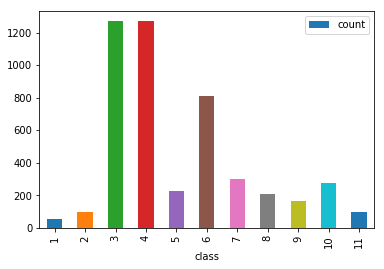

In [25]:
x = []
y = []
for key, item in df_train.groupby('class'):
    x.append(key)
    y.append(len(item))
    
df_distribution = pd.DataFrame(data={'class': x, 'count': y})
df_distribution.plot(kind='bar', x='class', y='count')

#### 可以看出来数据集里实例的分布并不均匀, 分类为3, 4, 6的实例占了大多数. 所以在后续的处理过程中要避免数据分布对结果的影响.